# Fit Fragments

### Libraries

In [1]:
import sys

sys.path.append("..")

In [2]:
import open3d as o3d
import numpy as np
import seaborn as sns
import pandas as pd

import re, os
from io import StringIO

import py3Dmol

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import MolDrawing, DrawingOptions

PandasTools.InstallPandasTools()

import ipywidgets as widgets
from IPython.display import HTML

import copy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2021-08-10 13:46:25,742 - __init__ - Enabling RDKit 2021.03.3 jupyter extensions


In [3]:
from score_pcd import fit_and_score

## SENSAAS

### Imatinib (Test)

In [4]:
%%bash
export PATH=${PWD}/../../sensaas:${PATH}
python ../../sensaas/meta-sensaas.py ligands/imatinib.sdf ligands/imatinib_parts.sdf

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
ligands/imatinib.sdf 1 - ligands/imatinib_parts.sdf 1 score-source gfit= 0.913 cfit= 0.830 hfit= 0.969 gfit+hfit= 1.882

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDT

In [5]:
mols = [mol for mol in Chem.SDMolSupplier("catsensaas.sdf")]
imatinib = next(Chem.SDMolSupplier("ligands/imatinib.sdf"))

def update(index=0):
    p = py3Dmol.view()
    p.addModel(Chem.MolToMolBlock(mols[index]), 'sdf')
    p.addModel(Chem.MolToMolBlock(imatinib), 'sdf')

    p.setStyle({"model": 1}, {'stick':{'colorscheme':'lightgreyCarbon'}})
    p.setStyle({"model": 0}, {'stick':{'colorscheme':'redCarbon'}})

    p.zoomTo()

    return p
    
_ = widgets.interact(update, index=widgets.IntSlider(min=0, max=len(mols)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='index', max=2), Output()), _dom_classes=('widget-interac…

## BRD4 Inhibitors

In [6]:
path = "ligands/BRD4"
files = [os.path.join(path, f) for f in os.listdir(path) if os.path.splitext(f)[-1] == ".pcd" and os.path.splitext(f)[0][-4:] == "tran"]

# Sort BRD4 ligand files by number
r = re.compile("\d{1,2}")
files.sort(key=lambda f: int(r.search(os.path.basename(f)).group()))

print(files)

pcds = []
mols = []
for f in files:
    pcd = o3d.io.read_point_cloud(f)
    pcds.append(pcd)

    s = Chem.SDMolSupplier(f.replace(".pcd", ".sdf"))
    mol = next(s)
    mols.append(mol)

['ligands/BRD4/ligand-1_tran.pcd', 'ligands/BRD4/ligand-2_tran.pcd', 'ligands/BRD4/ligand-3_tran.pcd', 'ligands/BRD4/ligand-4_tran.pcd', 'ligands/BRD4/ligand-5_tran.pcd', 'ligands/BRD4/ligand-6_tran.pcd', 'ligands/BRD4/ligand-7_tran.pcd', 'ligands/BRD4/ligand-8_tran.pcd', 'ligands/BRD4/ligand-9_tran.pcd', 'ligands/BRD4/ligand-10_tran.pcd']


### Generate Fragments Manyally from Single Bonds

In [7]:
molid = 9

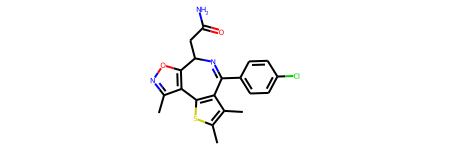

In [8]:
DrawingOptions.includeAtomNumbers=True


mol1 = copy.deepcopy(mols[molid])
mol1.Compute2DCoords()

mol1

In [9]:
def cut(mol):
    """
    Original source:
        Project: guacamol_baselines
        Author: BenevolentAI
        File: crossover.py
        License: MIT License
    """
    if not mol.HasSubstructMatch(Chem.MolFromSmarts('[*]-;!@[*]')):
        return None

    # List of atom pairs matching SMARTS pattern
    bis = mol.GetSubstructMatches(Chem.MolFromSmarts('[*]-;!@[*]'))  # single bond not in ring

    fragments = []
    for b in bis:
        # Bond between atom pair
        bs = [mol.GetBondBetweenAtoms(b[0], b[1]).GetIdx()]

        #f = Chem.FragmentOnBonds(mol, bs, addDummies=True, dummyLabels=[(1, 1)])
        f = Chem.FragmentOnBonds(mol, bs, addDummies=False, dummyLabels=[(1, 1)])

        try:
            # Pair of fragments
            mols = Chem.GetMolFrags(f, asMols=True, sanitizeFrags=True)

            # Look for fragments bigger than one heteroatom
            if mols[0].GetNumHeavyAtoms() > 1 and mols[1].GetNumHeavyAtoms() > 1:
                fragments.append(mols)
        except ValueError:
            fragments.appen(None)

    return fragments


In [10]:
frags = cut(mol1)
frags

[(<rdkit.Chem.rdchem.Mol at 0x7f0375765870>,
  <rdkit.Chem.rdchem.Mol at 0x7f0375765e70>),
 (<rdkit.Chem.rdchem.Mol at 0x7f03757656f0>,
  <rdkit.Chem.rdchem.Mol at 0x7f0375765630>),
 (<rdkit.Chem.rdchem.Mol at 0x7f0375746750>,
  <rdkit.Chem.rdchem.Mol at 0x7f0375746450>)]

In [11]:
df = pd.DataFrame(frags, columns=["frag1", "frag2"])

In [12]:
for idx, row in df.iterrows():
    mol1 = row["frag1"]
    mol2 = row["frag2"]

    with Chem.SDWriter(os.path.join(path, f"frag_{idx}_1.sdf")) as w:
        w.write(mol1, confId=0)

    with Chem.SDWriter(os.path.join(path, f"frag_{idx}_2.sdf")) as w:
        w.write(mol2, confId=0)

In [13]:
n_frags = len(frags)

n_frags_minus_one = n_frags - 1

n_frags

3

In [14]:
!ls ligands/BRD4 | grep frag

frag_0_1.pcd
frag_0_1.sdf
frag_0_2.pcd
frag_0_2.sdf
frag_1_1.pcd
frag_1_1.sdf
frag_1_2.pcd
frag_1_2.sdf
frag_2_1.pcd
frag_2_1.sdf
frag_2_2.pcd
frag_2_2.sdf


In [15]:
%%bash -s "$path" "$n_frags_minus_one"

# Python variable path passed to bash
# Can be accessed with $1

# Python variable n_frags passed to bash
# Can be accessed with $2

# Unfortunately molgrid does not work well with pybel
# molgrid_to_pcd needs to run within a Singularity container
# (RDKit and molgrid compiled from source!)
# See https://github.com/gnina/libmolgrid/issues/62

for FRAG in $(seq 0 $2)
do
    singularity run --nv --app python ../development/densitymatch.sif \
        ../molgrid_to_pcd.py ${PWD}/${1}/frag_${FRAG}_1.sdf -o ${PWD}/${1}/frag_${FRAG}_1.pcd \
            --ligmap ${PWD}/../files/ligmap

    singularity run --nv --app python ../development/densitymatch.sif \
        ../molgrid_to_pcd.py ${PWD}/${1}/frag_${FRAG}_2.sdf -o ${PWD}/${1}/frag_${FRAG}_2.pcd \
            --ligmap ${PWD}/../files/ligmap
done

In [16]:
!ls ligands/BRD4 | grep "frag.*\.pcd"

frag_0_1.pcd
frag_0_2.pcd
frag_1_1.pcd
frag_1_2.pcd
frag_2_1.pcd
frag_2_2.pcd


In [17]:
fpcds = []
fmols = []

files = [os.path.join(path, f"frag_{nf}_{i}.pcd") for nf in range(n_frags) for i in range(1, 3)]

print(files)

for f in files:
    pcd = o3d.io.read_point_cloud(f)
    fpcds.append(pcd)

    s = Chem.SDMolSupplier(f.replace(".pcd", ".sdf"))
    mol = next(s)
    fmols.append(mol)

print(fpcds)

['ligands/BRD4/frag_0_1.pcd', 'ligands/BRD4/frag_0_2.pcd', 'ligands/BRD4/frag_1_1.pcd', 'ligands/BRD4/frag_1_2.pcd', 'ligands/BRD4/frag_2_1.pcd', 'ligands/BRD4/frag_2_2.pcd']
[PointCloud with 200 points., PointCloud with 772 points., PointCloud with 850 points., PointCloud with 104 points., PointCloud with 818 points., PointCloud with 120 points.]


In [18]:
def align_frag_and_show(cidx, idx):
    """
    Align given conformer with original BRD4 ligand.
    """
    pcd1, pcd2 = fpcds[cidx], pcds[idx]
    mol1, mol2 = fmols[cidx], mols[idx]
    
    fit, cfit, tran = fit_and_score((pcd1, pcd2), voxel_size=0.5, threshold=0.5)

    print(cfit.fitness)

    # Get coordinates to transform
    coords = mol1.GetConformer(0).GetPositions()

    # Augment coordinates with ones
    coords_aug = np.ones((coords.shape[0], 4))
    coords_aug[:,:3] = coords

    # Compute new (transformed) coordinates
    coords_new = np.matmul(tran, coords_aug.T)[:3,:].T

    # Add new coordinates as conformer
    n_atoms = mol1.GetNumAtoms()
    conf = Chem.Conformer(n_atoms)
    for i in range(n_atoms):
        conf.SetAtomPosition(i, coords_new[i,:])

    _ = mol1.AddConformer(conf, assignId=True)

    # Create view
    p = py3Dmol.view()
    p.addModel(Chem.MolToMolBlock(mol1, confId=0),'sdf')
    p.addModel(Chem.MolToMolBlock(mol1, confId=1),'sdf')
    p.addModel(Chem.MolToMolBlock(mol2, confId=0),'sdf')

    p.setStyle({"model": 0}, {'stick':{'colorscheme':'lightgreyCarbon'}})
    p.setStyle({"model": 1}, {'stick':{'colorscheme':'redCarbon'}})
    p.setStyle({"model": 2}, {'stick':{'colorscheme':'greyCarbon'}})

    p.zoomTo()

    return p

In [19]:
align_frag_and_show(0, 9)

0.8


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [20]:
align_frag_and_show(1, 9)

0.6606217616580311


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [21]:
align_frag_and_show(2, 9)

0.5929411764705882


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [22]:
align_frag_and_show(4, 9)

0.6503667481662592


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [23]:
align_frag_and_show(5, 9)

0.8333333333333334


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [24]:
align_frag_and_show(5, 9)

0.8083333333333333


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol